<a href="https://colab.research.google.com/github/vincent4u/Plant_disease-classification-Msc_thesis-/blob/main/Untitled66.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==2.9.1

In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

# *Importing system libraries*

In [2]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# ***Creating important functions***


***Functions to Create DataFrame from Dataset***


In [3]:
# Function to generate file paths and corresponding labels from a given directory
def define_paths(data_dir):
    """
    This function iterates through directories and subdirectories within the provided data directory,
    collecting file paths and assigning them labels based on the parent directory they reside in.

    Parameters:
    - data_dir: The root directory where the data is stored.

    Returns:
    - A tuple containing two lists: filepaths (a list of absolute paths to all files) and labels (a list of labels corresponding to each file).
    """
    filepaths = []  # List to store absolute paths of all files
    labels = []     # List to store labels for each file

    # Get a list of all folders/directories in the data directory
    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)  # Construct the full path to the current folder
        filelist = os.listdir(foldpath)           # Get a list of all files in the current folder

        for file in filelist:
            fpath = os.path.join(foldpath, file)  # Construct the full path to the current file
            filepaths.append(fpath)               # Append the file path to the list
            labels.append(fold)                   # Append the label (folder name) to the list

    return filepaths, labels


# Function to concatenate file paths and labels into a single DataFrame
def define_df(files, classes):
    """
    This function creates two pandas Series objects from the provided lists of file paths and labels,
    then concatenates these series side by side into a single DataFrame. This DataFrame will serve as the input
    for further processing, such as splitting into training, validation, and testing sets.

    Parameters:
    - files: A list of file paths.
    - classes: A list of labels corresponding to each file.

    Returns:
    - A DataFrame with two columns: 'filepaths' and 'labels', where 'filepaths' contains the paths to the files
      and 'labels' contains the corresponding labels.
    """
    Fseries = pd.Series(files, name='filepaths')  # Create a Series object for file paths
    Lseries = pd.Series(classes, name='labels')   # Create a Series object for labels

    return pd.concat([Fseries, Lseries], axis=1)  # Concatenate the two Series along the column axis


# Function to split the combined DataFrame into training, validation, and testing sets
def split_data(data_dir):
    """
    This function performs the following steps:
    1. Generates file paths and labels using the `define_paths` function.
    2. Combines these into a DataFrame using the `define_df` function.
    3. Splits the resulting DataFrame into training, validation, and testing sets, ensuring that the distribution
       of labels across these sets remains consistent (stratified sampling).

    Parameters:
    - data_dir: The root directory where the data is stored.

    Returns:
    - A tuple containing three DataFrames: train_df (for training), valid_df (for validation), and test_df (for testing).
    """
    # Step 1: Generate file paths and labels
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)

    # Extracting the labels for stratification
    strat = df['labels']

    # Step 2: Split the DataFrame into training and dummy sets (80% training)
    train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=strat)

    # Step 3: Further split the dummy set into validation and testing sets (50% validation)
    strat = dummy_df['labels']  # Re-extracting the labels for stratification
    valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat)

    return train_df, valid_df, test_df


***Function to generate trainig,validation and test split set from th diretory***

In [4]:
def create_gens(train_df, valid_df, test_df, batch_size):
    '''
    This function prepares image data generators for training, validation, and testing datasets.
    It uses Keras' ImageDataGenerator to preprocess images and convert them into tensors
    suitable for model training. The preprocessing includes resizing images to a standard size,
    applying data augmentation techniques like horizontal flipping, and converting images
    into categorical labels based on their file paths and labels columns.

    Parameters:
    - train_df: DataFrame containing training dataset with file paths and corresponding labels.
    - valid_df: DataFrame containing validation dataset with file paths and corresponding labels.
    - test_df: DataFrame containing testing dataset with file paths and corresponding labels.
    - batch_size: Number of samples per gradient update during training time.

    Returns:
    - train_gen: An instance of ImageDataGenerator for the training set.
    - valid_gen: An instance of ImageDataGenerator for the validation set.
    - test_gen: An instance of ImageDataGenerator for the testing set, using a custom batch size calculated to ensure that the total number of batches does not exceed 80.
    '''

    # Define the dimensions of the input images and the number of color channels.
    img_size = (224, 224)                                                       # Standard input size for the model.
    channels = 3                                                                # Using RGB images.
    color = 'rgb'                                                               # Color mode for the images.
    img_shape = (img_size[0], img_size[1], channels)                            # Shape of the input images.

    # Calculate the optimal batch size for the test set to ensure efficient memory usage.
    ts_length = len(test_df)  # Total number of samples in the test set.
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))  # Find the largest divisor of ts_length that divides evenly and keeps the number of batches below 80.
    test_steps = ts_length // test_batch_size                                   # Calculate the number of steps required to iterate over the entire test set.

    # Define a simple preprocessing function that returns the input image unchanged.
    def scalar(img):                                                                  # Placeholder function for demonstration purposes.
        return img

    # Create instances of ImageDataGenerator for both training and testing sets.
    tr_gen = ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)  # Apply horizontal flip for data augmentation.
    ts_gen = ImageDataGenerator(preprocessing_function=scalar)                        # No data augmentation for the test set.

    # Generate data generators for the training, validation, and test sets.
    train_gen = tr_gen.flow_from_dataframe(
        train_df,
        x_col='filepaths',                                                             # Column name for file paths in the DataFrame.
        y_col='labels',                                                                # Column name for labels in the DataFrame.
        target_size=img_size,                                                          # Resize images to the specified size.
        class_mode='categorical',                                                      # Use categorical labels.
        color_mode=color,                                                              # Specify the color mode.
        shuffle=True,                                                                  # Shuffle the data.
        batch_size=batch_size                                                          # Batch size for training.
    )

    valid_gen = ts_gen.flow_from_dataframe(
        valid_df,
        x_col='filepaths',
        y_col='labels',
        target_size=img_size,
        class_mode='categorical',
        color_mode=color,
        shuffle=True,
        batch_size=batch_size
    )

    # For the test set, use the custom batch size calculation and disable shuffling.
    test_gen = ts_gen.flow_from_dataframe(
        test_df,
        x_col='filepaths',
        y_col='labels',
        target_size=img_size,
        class_mode='categorical',
        color_mode=color,
        shuffle=False,                                  # Do not shuffle the test set.
        batch_size=test_batch_size
    )

    return train_gen, valid_gen, test_gen


# ***Viewing the Data sample***


In [5]:
def show_images(gen):
    '''
    This function displays a sample of images generated by the given data generator.
    It retrieves a batch of images along with their labels from the generator,
    selects a subset of these images for display, and then plots them using matplotlib.
    Each image is labeled with its predicted class name.

    Parameters:
    - gen: A data generator object, typically returned by methods like flow_from_directory() or
    flow_from_dataframe() in Keras' ImageDataGenerator.

    Notes:
    - The function assumes that the data generator yields batches of images and their corresponding labels.
    - The number of images displayed is limited to a maximum of 25 to avoid cluttering the plot.
    - Images are normalized to the range [0, 255] for better visualization.
    '''

    # Retrieve the mapping between class indices and class names from the generator.
    g_dict = gen.class_indices                                                        # Dictionary mapping class names to indices. defines dictionary {'class': index}
    classes = list(g_dict.keys())                                                     # List of class names extracted from the dictionary keys.

    # Fetch a batch of images and their labels from the generator.
    images, labels = next(gen)                                                        # Get a batch of images and their labels.

    # Determine the number of images to display, up to a maximum of 25.
    length = len(labels)                                                              # Length of the batch.
    sample = min(length, 25)                                                          # Limit the number of displayed images to 25 or fewer.

    # Initialize a figure for plotting the images.
    plt.figure(figsize=(20, 20))                                                      # Set the figure size.

    # Loop through the selected images and plot each one.
    for i in range(sample):
        plt.subplot(5, 5, i + 1)                                                      # Position the subplot.

        # Normalize the image pixel values to the range [0, 255].
        image = images[i] / 255

        # Display the image.
        plt.imshow(image)

        # Retrieve the label index of the current image.
        index = np.argmax(labels[i])

        # Extract the class name corresponding to the label index.
        class_name = classes[index]

        # Add a title to the subplot indicating the class name.
        plt.title(class_name, color='blue', fontsize=12)

        # Hide axes for cleaner visualization.
        plt.axis('off')

    # Display the figure with the plotted images.
    plt.show()


# ***Implementing a callback***
 creating a call back class

In [6]:
class MyCallback(keras.callbacks.Callback):
    """
    Custom callback class for dynamic learning rate adjustment and
    early stopping based on training and validation metrics.

    This callback dynamically adjusts the learning rate based on the performance of the model
    on the training and validation datasets. It also implements early stopping based on a specified number
    of epochs without improvement in validation loss.

    Parameters:
    - model: The Keras model to which this callback is attached.
    - patience: Number of epochs with no improvement after which learning rate is reduced.
    - stop_patience: Number of times the learning rate can be reduced before stopping training.
    - threshold: Training accuracy threshold for adjusting the learning rate based on validation loss.
    - factor: Factor by which to reduce the learning rate.
    - batches: Number of training batches to run per epoch.
    - epochs: Total number of epochs to train for.
    - ask_epoch: Optional parameter to prompt the user to decide whether to continue training past
    a certain epoch.
    """

    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch=None):
        super(MyCallback, self).__init__()
        self.model = model                    # Reference to the Keras model instance
        self.patience = patience              # Number of epochs with no improvement after which learning rate is reduced
        self.stop_patience = stop_patience    # Number of times the learning rate can be reduced before stopping training
        self.threshold = threshold            # Training accuracy threshold for adjusting the learning rate based on validation loss
        self.factor = factor                  # Factor by which to reduce the learning rate
        self.batches = batches                # Number of training batches to run per epoch
        self.epochs = epochs                  # Total number of epochs to train for
        self.ask_epoch = ask_epoch            # Epoch at which the user is prompted to decide whether to continue training
        self.ask_epoch_initial = ask_epoch    # Saved initial value of ask_epoch for potential restoration

        self.count = 0                        # Counter for tracking the number of times the learning rate has been reduced without improvement
        self.stop_count = 0                   # Counter for tracking the number of times the learning rate has been reduced consecutively without improvement, triggering early stopping
        self.best_epoch = 1                   # Best epoch identified during training, based on the lowest validation loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr))  # Initial learning rate of the model's optimizer
        self.highest_tracc = 0.0              # Highest training accuracy observed during training
        self.lowest_vloss = np.inf            # Lowest validation loss observed during training
        self.best_weights = self.model.get_weights()  # Weights of the model at the best epoch, saved for potential restoration
        self.initial_weights = self.model.get_weights()  # Initial weights of the model, saved for potential restoration

    def on_train_begin(self, logs=None):
        """
        Called at the beginning of training.
        Prompts the user to confirm whether they want to proceed with training.
        """
        msg = 'Do you want model to ask you if you want to halt the training [y/n]?'
        print(msg)
        ans = input('')
        if ans in ['Y', 'y']:
            self.ask_permission = 1
        elif ans in ['N', 'n']:
            self.ask_permission = 0

        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()   #Records the starting time of the training process using the time.time() function.


    def on_train_end(self, logs=None):
        """
        Called at the end of training.
        Prints the total training duration and restores the model to its best weights.
        """
        stop_time = time.time()                                       #Records the stopping time of the training process using the time.time() function.
        tr_duration = stop_time - self.start_time                     # Calculating the training duration time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        self.model.set_weights(self.best_weights)                     # Restores and sets the model's weights to the best performing weight configuration found during training.


    def on_train_batch_end(self, batch, logs=None):
        """
        Called at the end of each batch.
        Prints the progress of the batch processing.
        """
        acc = logs.get('accuracy') * 100                            # Extracting and converting the model's accuracy to percentage
        loss = logs.get('loss')                                     # Obtaining the current epoch's loss value

        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '')



    def on_epoch_begin(self, epoch, logs=None):
        """
        Called at the beginning of each epoch.
        Records the start time of the epoch.
        """
        self.ep_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        """
        Called at the end of each epoch.
        Adjusts the learning rate based on the performance of the model on the training and validation datasets.
        Implements early stopping based on a specified number of epochs without improvement in validation loss.
        """
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))        # Retrieves the current learning rate of the model's optimizer
        current_lr = lr                                                        # Stores the current learning rate for comparison
        acc = logs.get('accuracy')                                             # Fetches the training accuracy from the logs
        v_acc = logs.get('val_accuracy')                                       # Retrieves the validation accuracy from the logs
        loss = logs.get('loss')                                                # Gets the training loss from the logs
        v_loss = logs.get('val_loss')                                          # Obtains the validation loss from the logs

        if acc < self.threshold:
            # Switching the monitoring metric to accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                # Calculating improvement in accuracy
                pimprov = (acc - self.highest_tracc) * 100 / self.highest_tracc

            # Updating best accuracy and weights if new high is set
            if acc > self.highest_tracc:
                self.highest_tracc = acc
                self.best_weights = self.model.get_weights()
                self.count = 0
                self.stop_count = 0

                # Updating lowest validation loss if applicable
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1

            else:
                # Reducing learning rate if patience is met
                if self.count >= self.patience - 1:
                    lr = lr * self.factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr)
                    self.count = 0
                    self.stop_count = self.stop_count + 1
                    # Updating lowest validation loss if applicable
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    # Incrementing counter for epochs without improvement
                    self.count = self.count + 1

        else:
            # Switching the monitoring metric to validation loss
            monitor = 'val_loss'
            # Resetting improvement calculation for the first epoch
            if epoch == 0:
                pimprov = 0.0
            else:
                # Calculating improvement in validation loss
                pimprov = (self.lowest_vloss - v_loss) * 100 / self.lowest_vloss

            # Updating lowest validation loss and weights if new low is set
            if v_loss < self.lowest_vloss:
                self.lowest_vloss = v_loss
                self.best_weights = self.model.get_weights()
                self.count = 0
                self.stop_count = 0
                self.best_epoch = epoch + 1

            else:
                # Reducing learning rate if patience is met
                if self.count >= self.patience - 1:
                    lr = lr * self.factor
                    self.stop_count = self.stop_count + 1
                    self.count = 0
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr)

                else:
                    # Incrementing counter for epochs without improvemen
                    self.count = self.count + 1

                # Updating highest training accuracy if applicable
                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        # Stopping the training if maximum learning rate adjustments without improvement are reached
        if self.stop_count > self.stop_patience - 1:
            msg = f'training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True

        else:
            # Handling user request to halt training or adjust the number of epochs to run
            if self.ask_epoch!= None and self.ask_permission!= 0:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)

                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True       # stop training

                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f'training will continue until epoch {str(self.ask_epoch)}'
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)

                        except Exception:
                            print('Invalid')


# ***Function for Plotting the Training History***

In [7]:
def plot_training(hist):
    '''
    This function takes a training model's history object and plots the training and validation accuracy and loss over epochs,
    highlighting the epoch with the best validation loss and accuracy.
    '''

    # Extracting training and validation metrics from the history object
    tr_acc = hist.history['accuracy']                                       # Training accuracy
    tr_loss = hist.history['loss']                                          # Training loss
    val_acc = hist.history['val_accuracy']                                  # Validation accuracy
    val_loss = hist.history['val_loss']                                     # Validation loss

    # Identifying the epoch with the lowest validation loss and highest validation accuracy
    index_loss = np.argmin(val_loss)                                        # Index of the epoch with the lowest validation loss
    val_lowest = val_loss[index_loss]                                       # Value of the lowest validation loss
    index_acc = np.argmax(val_acc)                                          # Index of the epoch with the highest validation accuracy
    acc_highest = val_acc[index_acc]                                        # Value of the highest validation accuracy

    # Creating a list of epochs for plotting
    Epochs = [i+1 for i in range(len(tr_acc))]                              # Adjusting epoch numbers to start from 1

    # Labels for the best epoch in terms of loss and accuracy
    loss_label = f'best epoch= {str(index_loss + 1)}'                        # Label for the best epoch in terms of validation loss
    acc_label = f'best epoch= {str(index_acc + 1)}'                          # Label for the best epoch in terms of validation accuracy

    # Plotting training and validation loss
    plt.figure(figsize=(20, 8))                                             # Setting figure size
    plt.style.use('fivethirtyeight')                                        # Using a style for the plot

    plt.subplot(1, 2, 1)                                                    # Subplot for loss
    plt.plot(Epochs, tr_loss, 'r', label='Training loss')                   # Plotting training loss
    plt.plot(Epochs, val_loss, 'g', label='Validation loss')                 # Plotting validation loss
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)  # Highlighting the best epoch in terms of validation loss
    plt.title('Training and Validation Loss')                                   # Title for the subplot
    plt.xlabel('Epochs')                                                    # X-axis label
    plt.ylabel('Loss')                                                      # Y-axis label
    plt.legend()                                                            # Displaying legend

    plt.subplot(1, 2, 2)                                                    # Subplot for accuracy
    plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')                # Plotting training accuracy
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')             # Plotting validation accuracy
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)  # Highlighting the best epoch in terms of validation accuracy
    plt.title('Training and Validation Accuracy')                               # Title for the subplot
    plt.xlabel('Epochs')                                                        # X-axis label
    plt.ylabel('Accuracy')                                                      # Y-axis label
    plt.legend()                                                                # Displaying legend

    plt.tight_layout()                                                          # Adjusting layout to prevent overlapping labels
    plt.show()                                                                  # Displaying the plot


# ***Importing and Reading the Dataset from Kaggle***

In [ ]:
# I have already done step 1 with the seceret thing
#Step 2: Access and Export your Kaggle secrets to the environment
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

#Step 3: Download Dataset :
!kaggle datasets download -d emmarex/plantdisease
# !kaggle datasets download -d abdallahalidev/plantvillage-dataset

! mkdir data_sets
! unzip plantdisease.zip -d data_sets

# ! mkdir data_vin
# ! unzip plantvillage-dataset.zip -d data_vin


# ***Splitting Dataset into training, Validation and testing***

Found 16510 validated image filenames belonging to 15 classes.
Found 2064 validated image filenames belonging to 15 classes.
Found 2064 validated image filenames belonging to 15 classes.


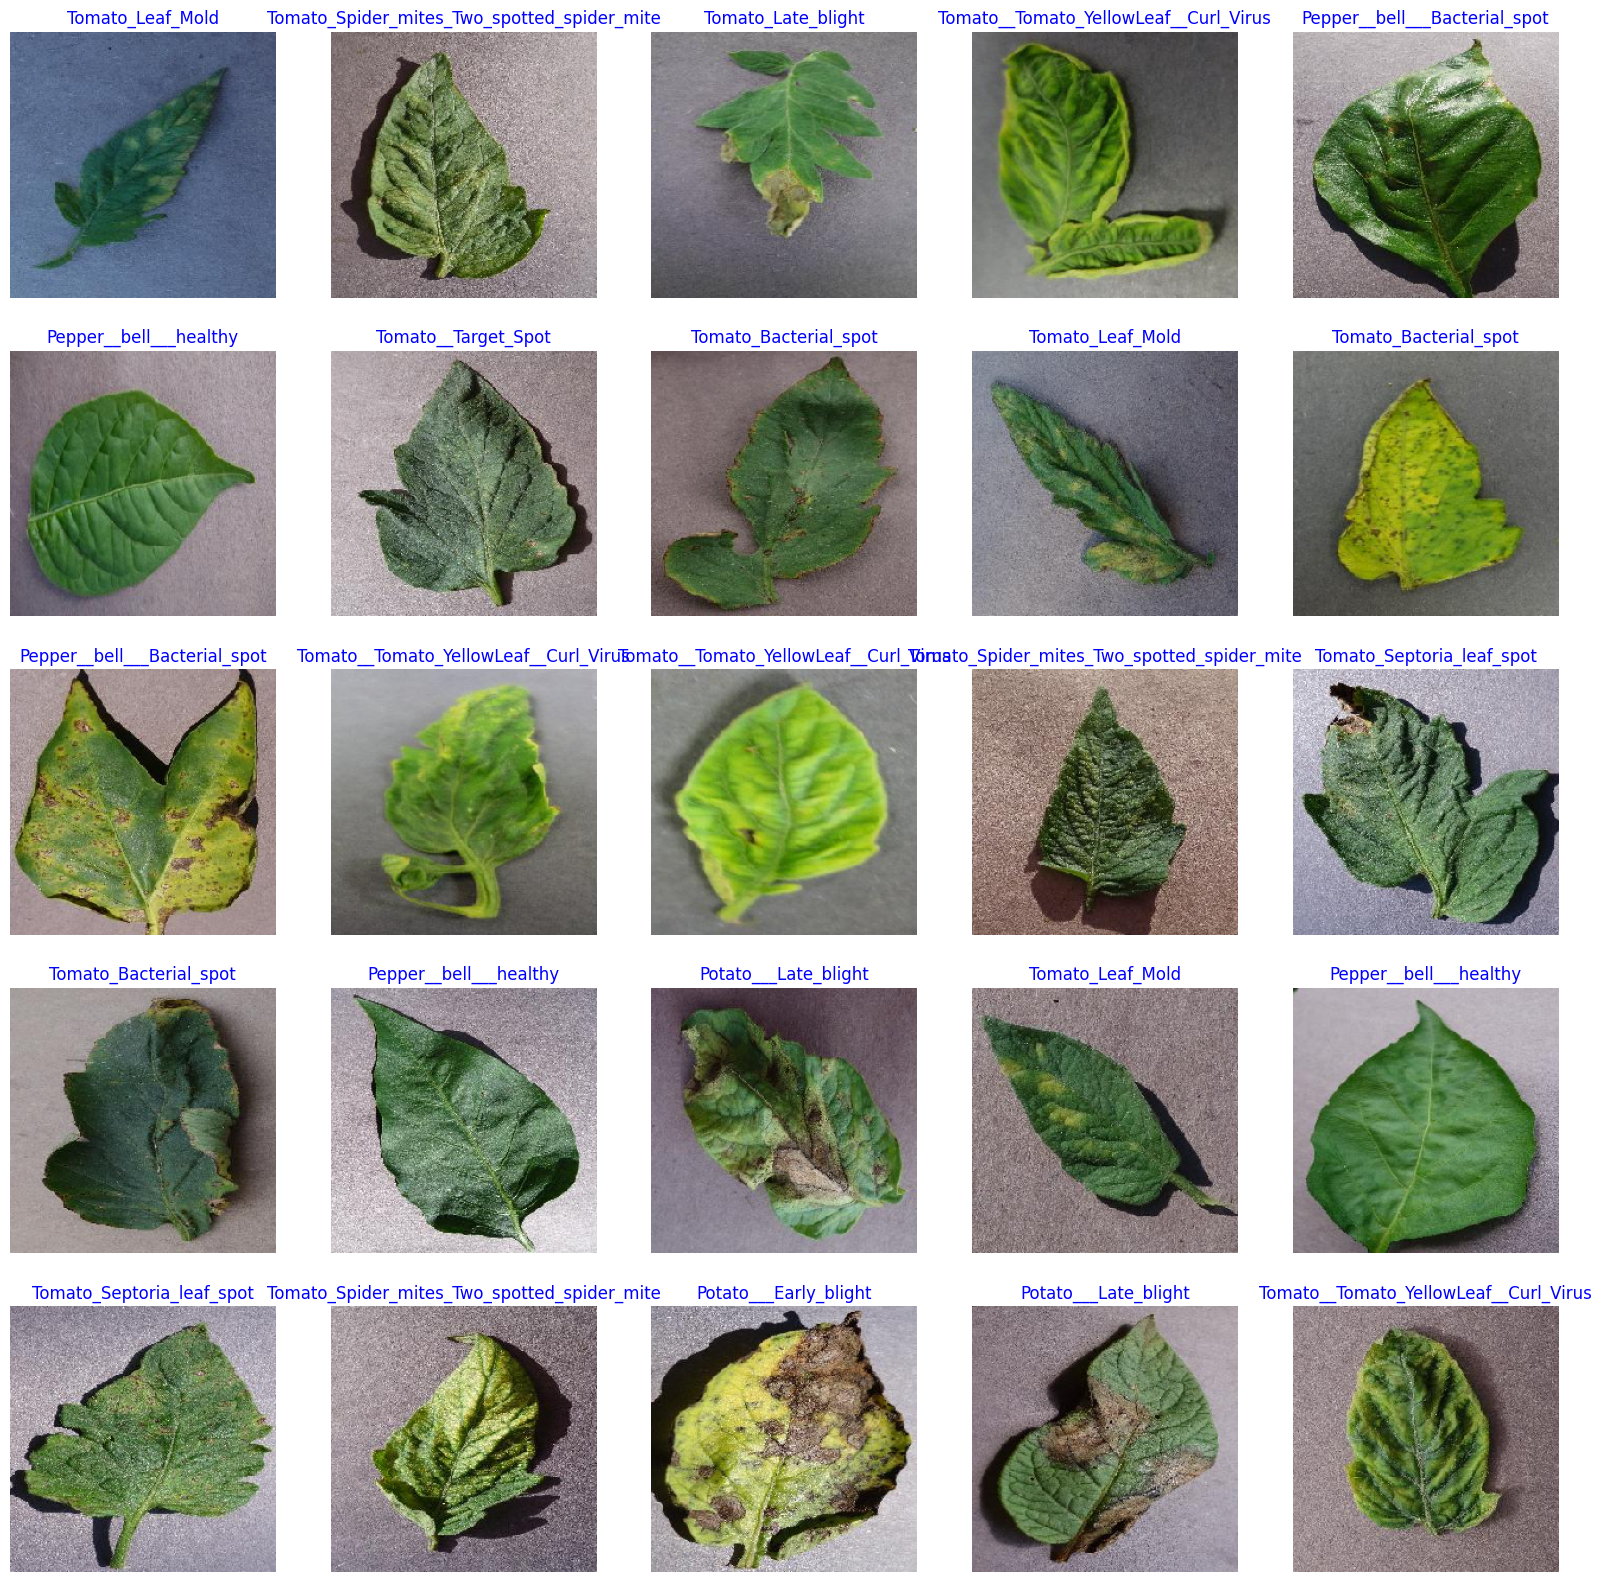

In [9]:

data_dir = '/content/data_sets/plantvillage/PlantVillage'                 #The Plant Village directory in Kaggle



try:
    # Get splitted data
    train_df, valid_df, test_df = split_data(data_dir)

    # Get Generators
    batch_size = 400
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

    # visualizing some images from the training set
    show_images(train_gen)

except Exception as e:
    print('Invalid Input:', str(e))

# ***Creating a Generic Model***

In [10]:
# Defining the dimensions of the input images and the number of color channels.
img_size = (224, 224)                                                 # Standard input size for the model. Common sizes include 224x224, 299x299, etc., depending on the pre-trained model used.
channels = 3                                                          # Using RGB images. Other options could be grayscale (1 channel) or RGBA (4 channels including alpha transparency).

# Combine the height, width, and number of channels to form the shape of the input images.
img_shape = (img_size[0], img_size[1], channels)                      # This shape is used to configure the input layer of the neural network.

# Determine the number of classes in the dataset by counting the unique labels present in the training generator.
class_count = len(list(train_gen.class_indices.keys()))                # This count is used to specify the number of neurons in the final dense layer of the model, matching the number of classes.

# Load a pre-trained EfficientNetB3 model without the top classification layer. This model has been trained on the ImageNet dataset.
# We specify 'include_top=False' to remove the final classification layer, allowing us to add our own.
# 'weights="imagenet"' loads the model pre-trained on ImageNet, which can help improve performance on similar tasks.
# 'input_shape=img_shape' ensures the model expects inputs of the correct shape.
# 'pooling="max"' applies max pooling to the feature maps before passing them to the fully connected layers, reducing dimensionality.
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

# Build the sequential model by stacking layers on top of the base model.
# The base model is added first, followed by additional layers for fine-tuning and classification.
model = Sequential([
    base_model,
    # Add a Batch Normalization layer to normalize the activations of the previous layer at each batch, i.e., apply a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1.
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    # Add a Dense layer with 256 units. Regularization is applied to prevent overfitting.
    Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006), bias_regularizer=regularizers.l1(0.006), activation='relu'),
    # Introduce dropout to reduce overfitting by randomly setting a fraction of input units to 0 at each update during training time.
    Dropout(rate=0.45, seed=123),
    # Final Dense layer with a softmax activation function for multi-class classification. The number of neurons matches the number of classes.
    Dense(class_count, activation='softmax')
])

# Compile the model with the Adamax optimizer, specifying the learning rate, loss function, and evaluation metric.
model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture, showing the layers and their configurations.
model.summary()


43941136/43941136 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 15)                3855      
                                                         

# ***Activating the Callback***

In [14]:
# # Set batch size for training.
# batch_size = 40

# # Define the total number of epochs for training.
# epochs = 40

# # Patience parameter for early stopping; specifies the number of epochs to wait before adjusting the learning rate if no improvement is observed.
# patience = 1

# # Stop patience parameter for early stopping; specifies the number of epochs to wait before stopping training if no improvement is observed.
# stop_patience = 3

# # Threshold for adjusting the monitored metric during training; if the training accuracy falls below this threshold, switch to monitoring validation loss instead.
# threshold = 0.9

# # Factor by which to reduce the learning rate when adjusting it during training.
# factor = 0.5

# # Epoch at which to prompt the user to decide whether to continue training or halt.
# ask_epoch = 5

# # Calculate the total number of training batches per epoch.
# batches = int(np.ceil(len(train_gen.labels) / batch_size))

# # Configure callbacks for model training, including early stopping and learning rate adjustment.
# callbacks = [
#     MyCallback(model=model, patience=patience, stop_patience=stop_patience, threshold=threshold,
#                factor=factor, batches=batches, epochs=epochs, ask_epoch=ask_epoch)
# ]
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

batch_size = 40   # set batch size for training
epochs = 40   # number of all epochs in training
patience = 1   #number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 3   # number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9   # if train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5   # factor to reduce lr by
ask_epoch = 5   # number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))    # number of training batch to run per epoch

callbacks = [MyCallback(model= model, patience= patience, stop_patience= stop_patience, threshold= threshold,
            factor= factor, batches= batches, epochs= epochs, ask_epoch= ask_epoch )]

history = model.fit(x= train_gen, epochs= epochs, verbose= 0, callbacks= callbacks,
                    validation_data= valid_gen, validation_steps= None, shuffle= False)




Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization_1 (Bat  (None, 1536)              6144      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 256)               393472    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 15)                3855      
                                                                 
Total params: 11187006 (42.68 MB)
Trainable params: 11

ResourceExhaustedError: Graph execution error:

Detected at node sequential_1/efficientnetb3/block2a_expand_bn/FusedBatchNormV3 defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-14-7c2991180b33>", line 65, in <cell line: 65>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/sequential.py", line 398, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/normalization/batch_normalization.py", line 597, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/normalization/batch_normalization.py", line 990, in _fused_batch_norm

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/control_flow_util.py", line 108, in smart_cond

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/normalization/batch_normalization.py", line 964, in _fused_batch_norm_training

OOM when allocating tensor with shape[400,112,112,144] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_1/efficientnetb3/block2a_expand_bn/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_100259]

# ***Training the model***

modules loaded
Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
plantdisease.zip: Skipping, found more recently modified local copy (use --force to force download)
mkdir: cannot create directory ‘data_sets’: File exists
Archive:  plantdisease.zip
replace data_sets/PlantVillage/Pepper__bell___Bacterial_spot/0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: Found 16510 validated image filenames belonging to 15 classes.
Found 2064 validated image filenames belonging to 15 classes.
Found 2064 validated image filenames belonging to 15 classes.


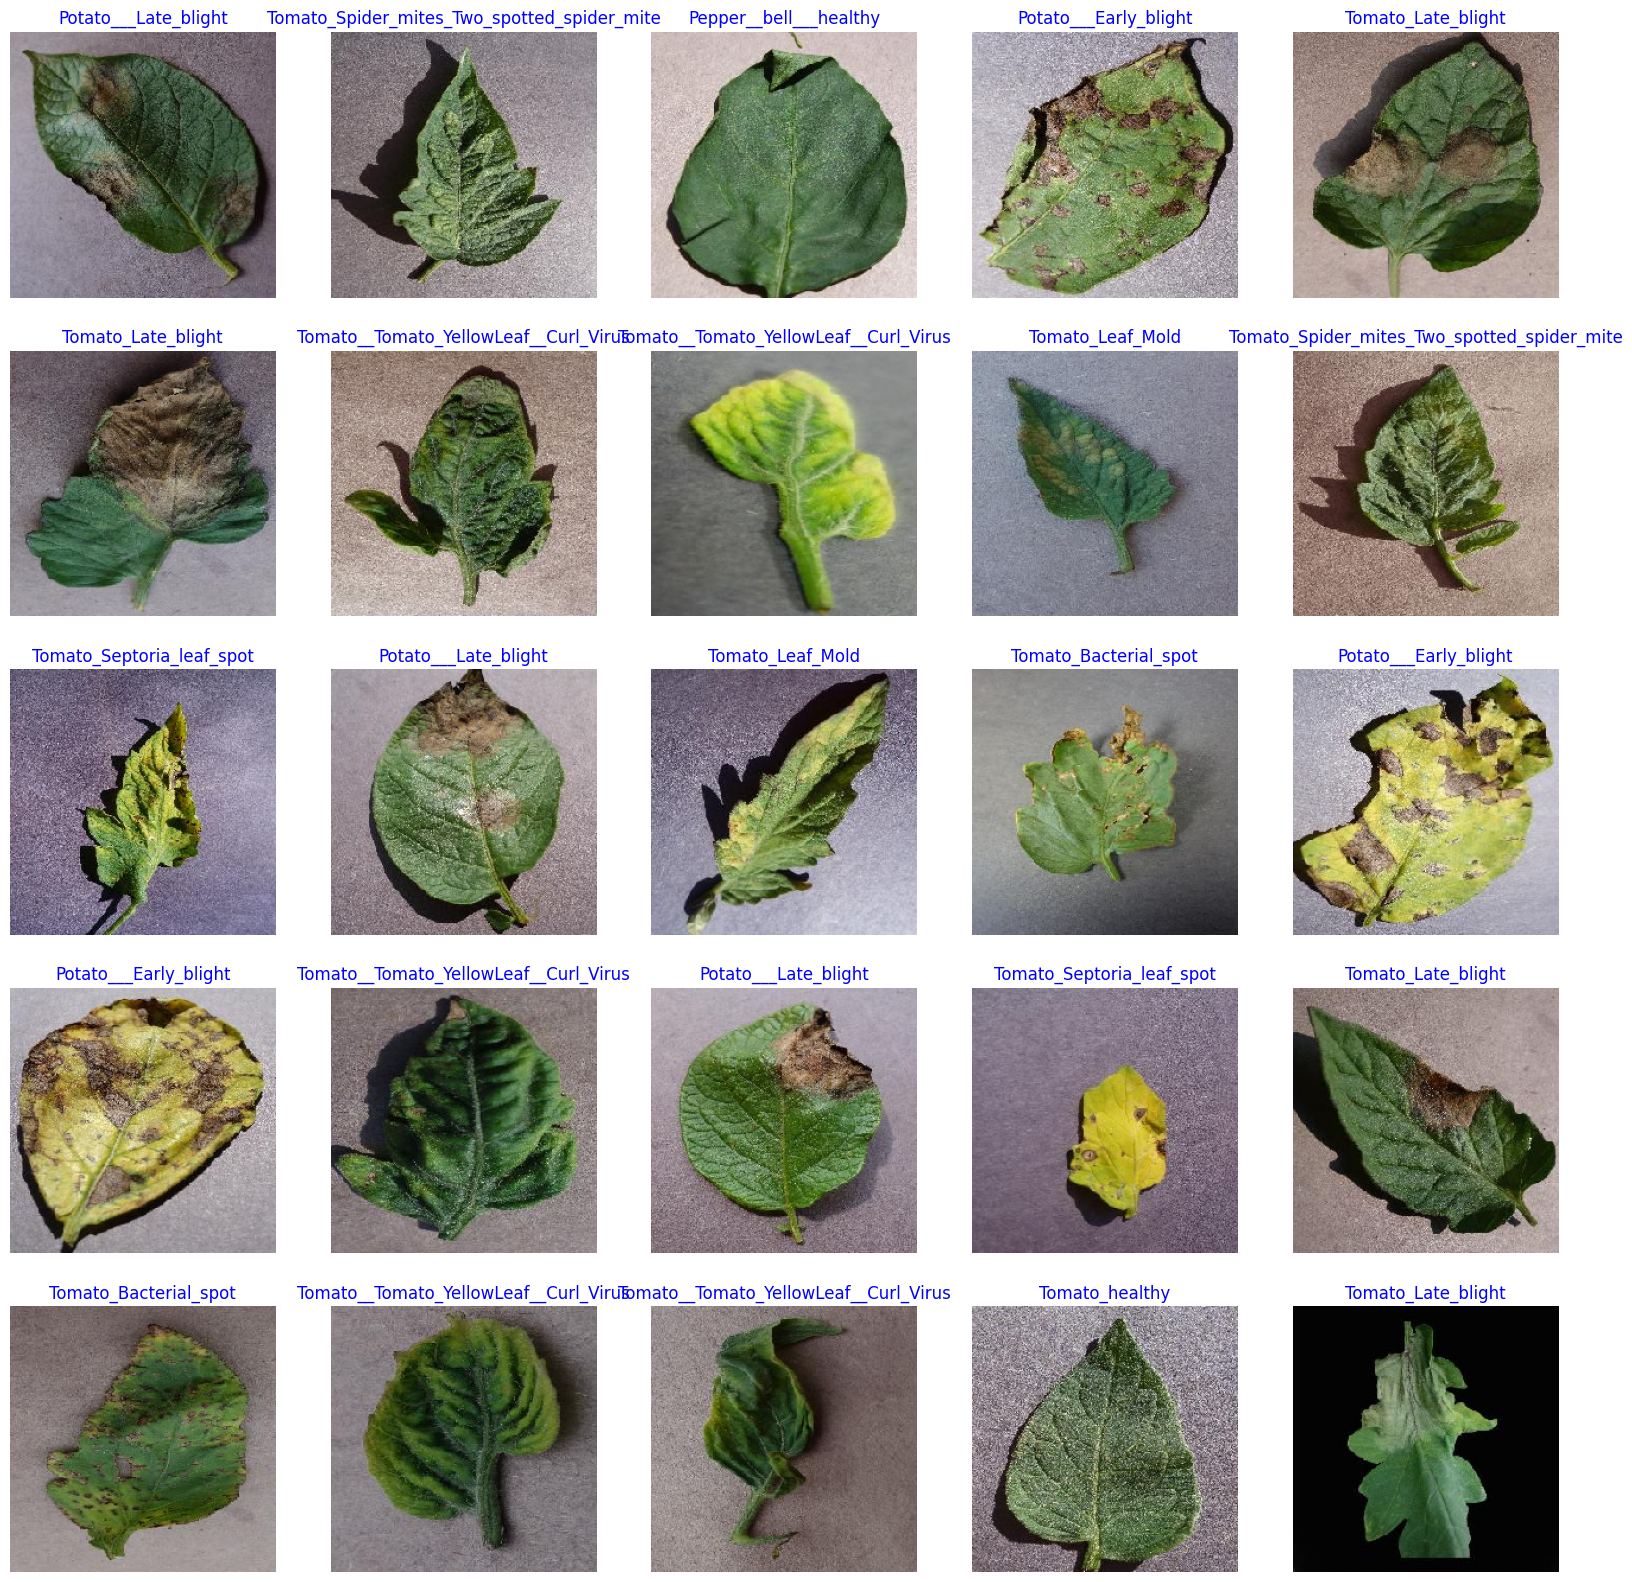

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization_2 (Bat  (None, 1536)              6144      
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 256)               393472    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 15)                3855      
                                                                 
Total params: 11187006 (42.68 MB)
Trainable params: 11

In [15]:
# GENERAL OVERVIEW OF THE WORKING MODEL
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

# Generate data paths with labels
def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

# Split dataframe to train, valid, and test
def split_data(data_dir):
    # train dataframe
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    # valid and test dataframe
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

    return train_df, valid_df, test_df

def create_gens (train_df, valid_df, test_df, batch_size):
    '''
    This function takes train, validation, and test dataframe and fit them into image data generator, because model takes data from image data generator.
    Image data generator converts images into tensors. '''


    # define model parameters
    img_size = (224, 224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

def show_images(gen):
    '''
    This function take the data generator and show sample of the images
    '''

    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor # factor by which to reduce the learning rate
        self.batches = batches # number of training batch to run per epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training

        # callback variables
        self.count = 0 # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1   # epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initial learning rate and save it
        self.highest_tracc = 0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf # set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights = self.model.get_weights()   # save initial weights if they have to get restored

    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):
        msg = 'Do you want model asks you to halt the training [y/n] ?'
        print(msg)
        ans = input('')
        if ans in ['Y', 'y']:
            self.ask_permission = 1
        elif ans in ['N', 'n']:
            self.ask_permission = 0

        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()


    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        # set the weights of the model to the best weights
        self.model.set_weights(self.best_weights)


    def on_train_batch_end(self, batch, logs= None):
        # get batch accuracy and loss
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')

        # prints over on the same line to show running batch count
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '')


    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()


    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0

            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss

            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch

            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer

                else:
                    self.count = self.count + 1 # increment the patience counter

                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training

        else:
            if self.ask_epoch != None and self.ask_permission != 0:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)

                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True # stop training

                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' training will continue until epoch {str(self.ask_epoch)}'
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)

                        except Exception:
                            print('Invalid')

def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']

    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    Epochs = [i+1 for i in range(len(tr_acc))]

    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()



# I have already done step 1 with the seceret thing
#Step 2: Access and Export your Kaggle secrets to the environment
from google.colab import userdata
import os
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

#Step 3: Download Dataset :
!kaggle datasets download -d emmarex/plantdisease
# !kaggle datasets download -d abdallahalidev/plantvillage-dataset

! mkdir data_sets
! unzip plantdisease.zip -d data_sets

# ! mkdir data_vin
# ! unzip plantvillage-dataset.zip -d data_vin


data_dir = '/content/data_sets/plantvillage/PlantVillage'
try:
    # Get splitted data
    train_df, valid_df, test_df = split_data(data_dir)

    # Get Generators
    batch_size = 40
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)
    show_images(train_gen)
except:
    print('Invalid Input')




# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

batch_size = 40   # set batch size for training
epochs = 40   # number of all epochs in training
patience = 1   #number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 3   # number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9   # if train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5   # factor to reduce lr by
ask_epoch = 5   # number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))    # number of training batch to run per epoch

callbacks = [MyCallback(model= model, patience= patience, stop_patience= stop_patience, threshold= threshold,
            factor= factor, batches= batches, epochs= epochs, ask_epoch= ask_epoch )]

history = model.fit(x= train_gen, epochs= epochs, verbose= 0, callbacks= callbacks,
                    validation_data= valid_gen, validation_steps= None, shuffle= False)




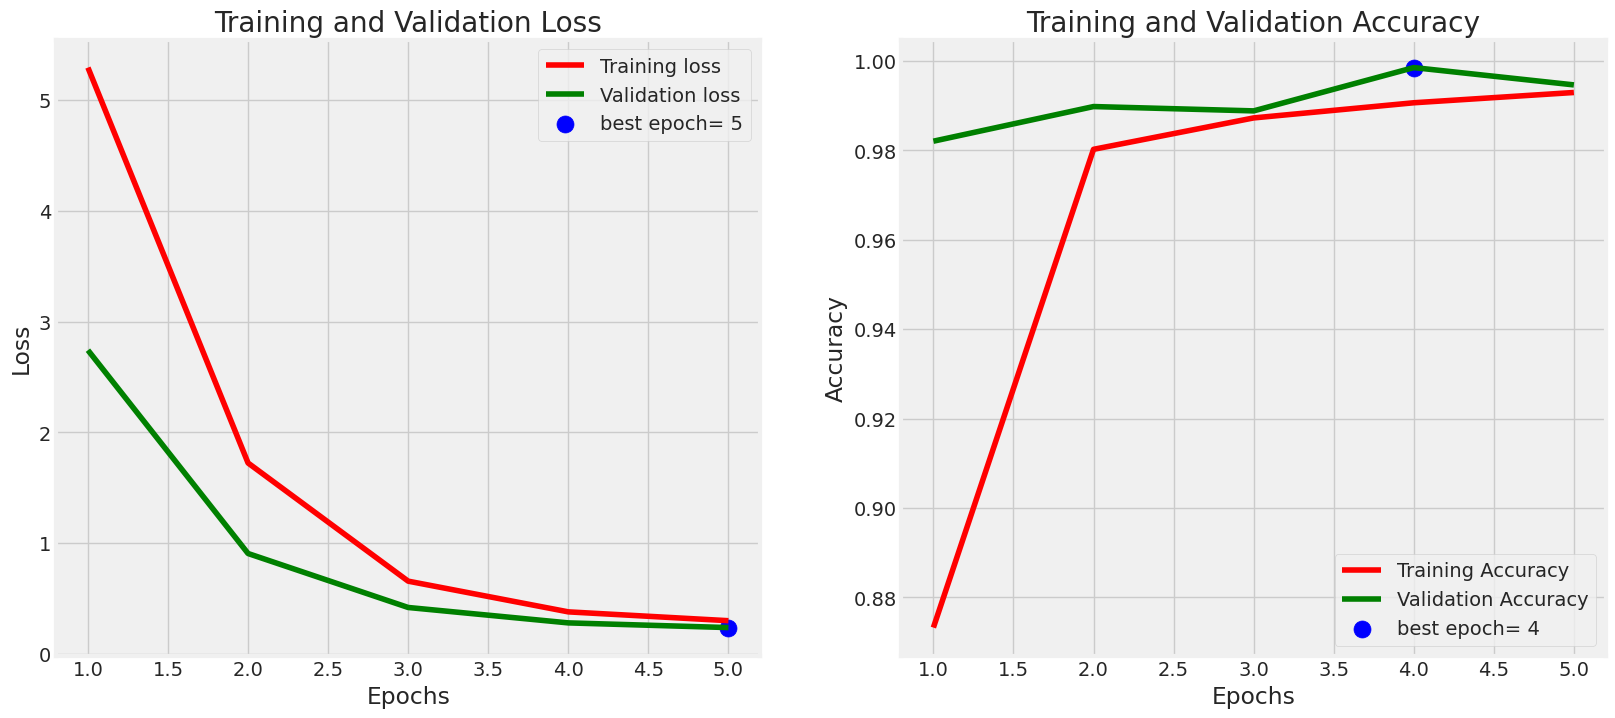

43/43 [==============================] - 10s 175ms/step - loss: 0.2366 - accuracy: 0.9952
Train Loss:  0.223119854927063
Train Accuracy:  0.9994186162948608
--------------------
Validation Loss:  0.24078239500522614
Validation Accuracy:  0.9936046600341797
--------------------
Test Loss:  0.23661011457443237
Test Accuracy:  0.9951550364494324
[ 8  2 12 ...  5  7  7]
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       1.00      0.97      0.98        99
                     Pepper__bell___healthy       0.97      1.00      0.99       148
                      Potato___Early_blight       1.00      1.00      1.00       100
                       Potato___Late_blight       0.99      1.00      1.00       100
                           Potato___healthy       1.00      1.00      1.00        15
                      Tomato_Bacterial_spot       1.00      1.00      1.00       213
                        Tomato_Earl

In [16]:
plot_training(history)

ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)


g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))


model_name = model.input_names[0][:-6]
subject = 'Plant Village Disease'
acc = test_score[1] * 100
save_path = ''

# Save model
save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

# Save weights
weight_save_id = str(f'{model_name}-{subject}-weights.h5')
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')


class_dict = train_gen.class_indices
img_size = train_gen.image_shape
height = []
width = []
for _ in range(len(class_dict)):
    height.append(img_size[0])
    width.append(img_size[1])

Index_series = pd.Series(list(class_dict.values()), name= 'class_index')
Class_series = pd.Series(list(class_dict.keys()), name= 'class')
Height_series = pd.Series(height, name= 'height')
Width_series = pd.Series(width, name= 'width')
class_df = pd.concat([Index_series, Class_series, Height_series, Width_series], axis= 1)
csv_name = f'{subject}-class_dict.csv'
csv_save_loc = os.path.join(save_path, csv_name)
class_df.to_csv(csv_save_loc, index= False)
print(f'class csv file was saved as {csv_save_loc}')


# ***Implementing the EfficientNet***

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.regularizers import l1, l2
from tensorflow.python.profiler import profiler_v2 as profiler
import time
import numpy as np
import keras

# Assuming your model definition and compilation are done here
# model =...
# Defining the dimensions of the input images and the number of color channels.
img_size = (224, 224)  # Standard input size for the model. Common sizes include 224x224, 299x299, etc., depending on the pre-trained model used.
channels = 3  # Using RGB images. Other options could be grayscale (1 channel) or RGBA (4 channels including alpha transparency).

# Combine the height, width, and number of channels to form the shape of the input images.
img_shape = (img_size[0], img_size[1], channels)  # This shape is used to configure the input layer of the neural network.

# Determine the number of classes in the dataset by counting the unique labels present in the training generator.
class_count = len(list(train_gen.class_indices.keys()))  # This count is used to specify the number of neurons in the final dense layer of the model, matching the number of classes.

# Load a pre-trained EfficientNetB3 model without the top classification layer. This model has been trained on the ImageNet dataset.
# We specify 'include_top=False' to remove the final classification layer, allowing us to add our own.
# 'weights="imagenet"' loads the model pre-trained on ImageNet, which can help improve performance on similar tasks.
# 'input_shape=img_shape' ensures the model expects inputs of the correct shape.
# 'pooling="max"' applies max pooling to the feature maps before passing them to the fully connected layers, reducing dimensionality.
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

# Build the sequential model by stacking layers on top of the base model.
# The base model is added first, followed by additional layers for fine-tuning and classification.
model = Sequential([
    base_model,
    # Add a Batch Normalization layer to normalize the activations of the previous layer at each batch, i.e., apply a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1.
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    # Add a Dense layer with 256 units. Regularization is applied to prevent overfitting.
    Dense(256, kernel_regularizer=l2(l=0.016), activity_regularizer=l1(0.006), bias_regularizer=l1(0.006), activation='relu'),
    # Introduce dropout to reduce overfitting by randomly setting a fraction of input units to 0 at each update during training time.
    Dropout(rate=0.45, seed=123),
    # Final Dense layer with a softmax activation function for multi-class classification. The number of neurons matches the number of classes.
    Dense(class_count, activation='softmax')
])

# Compile the model with the Adamax optimizer, specifying the learning rate, loss function, and evaluation metric.
model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture, showing the layers and their configurations.
# model.summary()

# Define your callbacks, including the custom callback you've mentioned
# callbacks = [...]
class MyCallback(keras.callbacks.Callback):
    """
    Custom callback class for dynamic learning rate adjustment and
    early stopping based on training and validation metrics.

    This callback dynamically adjusts the learning rate based on the performance of the model
    on the training and validation datasets. It also implements early stopping based on a specified number
    of epochs without improvement in validation loss.

    Parameters:
    - model: The Keras model to which this callback is attached.
    - patience: Number of epochs with no improvement after which learning rate is reduced.
    - stop_patience: Number of times the learning rate can be reduced before stopping training.
    - threshold: Training accuracy threshold for adjusting the learning rate based on validation loss.
    - factor: Factor by which to reduce the learning rate.
    - batches: Number of training batches to run per epoch.
    - epochs: Total number of epochs to train for.
    - ask_epoch: Optional parameter to prompt the user to decide whether to continue training past
    a certain epoch.
    """

    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch=None):
        self.model = model                    # Reference to the Keras model instance
        self.patience = patience              # Number of epochs with no improvement after which learning rate is reduced
        self.stop_patience = stop_patience    # Number of times the learning rate can be reduced before stopping training
        self.threshold = threshold            # Training accuracy threshold for adjusting the learning rate based on validation loss
        self.factor = factor                  # Factor by which to reduce the learning rate
        self.batches = batches                # Number of training batches to run per epoch
        self.epochs = epochs                  # Total number of epochs to train for
        self.ask_epoch = ask_epoch            # Epoch at which the user is prompted to decide whether to continue training
        self.ask_epoch_initial = ask_epoch    # Saved initial value of ask_epoch for potential restoration
        self.count = 0                        # Counter for tracking the number of times the learning rate has been reduced without improvement
        self.stop_count = 0                   # Counter for tracking the number of times the learning rate has been reduced consecutively without improvement, triggering early stopping
        self.best_epoch = 1                   # Best epoch identified during training, based on the lowest validation loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr))  # Initial learning rate of the model's optimizer
        self.highest_tracc = 0.0              # Highest training accuracy observed during training
        self.lowest_vloss = np.inf            # Lowest validation loss observed during training
        self.best_weights = self.model.get_weights()  # Weights of the model at the best epoch, saved for potential restoration
        self.initial_weights = self.model.get_weights()  # Initial weights of the model, saved for potential restoration

    def on_train_begin(self, logs=None):
        """
        Called at the beginning of training.
        Prompts the user to confirm whether they want to proceed with training.
        """
        msg = 'Do you want model to ask you if you want to halt the training [y/n]?'
        print(msg)
        ans = input('')
        if ans in ['Y', 'y']:
            self.ask_permission = 1
        elif ans in ['N', 'n']:
            self.ask_permission = 0

        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()   #Records the starting time of the training process using the time.time() function.


    def on_train_end(self, logs=None):
        """
        Called at the end of training.
        Prints the total training duration and restores the model to its best weights.
        """
        stop_time = time.time()                                       #Records the stopping time of the training process using the time.time() function.
        tr_duration = stop_time - self.start_time                     # Calculating the training duration time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds'
        print(msg)

        self.model.set_weights(self.best_weights)                     # Restores and sets the model's weights to the best performing weight configuration found during training.


    def on_train_batch_end(self, batch, logs=None):
        """
        Called at the end of each batch.
        Prints the progress of the batch processing.
        """
        acc = logs.get('accuracy') * 100                            # Extracting and converting the model's accuracy to percentage
        loss = logs.get('loss')                                     # Obtaining the current epoch's loss value

        msg = '{0:20s}processing batch {1:} of {2:5d}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', batch, self.batches, acc, loss)
        print(msg, '\r', end='')

    def on_epoch_begin(self, epoch, logs=None):
        """
        Called at the beginning of each epoch.
        Sets the epoch start time.
        """
        self.epoch_start = time.time()                            # Stores the current time at the start of the epoch
        return

    def on_epoch_end(self, epoch, logs=None):
        """
        Called at the end of each epoch.
        Adjusts the learning rate based on the training performance.
        """
        monitor = 'val_loss'                                      # Variable that determines which metric to monitor for improvements
        current = logs.get(monitor)                               # Extracting the monitored metric (validation loss)
        acc = logs.get('accuracy') * 100                          # Extracting the model's accuracy for the current epoch
        v_acc = logs.get('val_accuracy') * 100                    # Extracting the validation accuracy for the current epoch
        loss = logs.get('loss')                                   # Extracting the training loss for the current epoch
        v_loss = logs.get('val_loss')                             # Extracting the validation loss for the current epoch

        stop_time = time.time()                                   # Recording the time at the end of the epoch
        duration = stop_time - self.epoch_start                   # Calculating the duration of the epoch

        if acc < self.threshold:                                  # Checking if the accuracy is below the threshold
            monitor = 'val_loss'                                  # Monitor validation loss if accuracy is below the threshold
        else:
            monitor = 'val_loss'                                  # Otherwise, monitor validation loss

        msg = f'{epoch + 1:^8}{loss:10.5f}{acc:9.2f}{v_loss:9.5f}{v_acc:9.2f}{self.initial_lr:8.5f}{self.initial_lr:8.5f}{monitor:10}{self.stop_count:10}{duration:8.2f}'
        print(msg)

        if current < self.lowest_vloss:
            self.lowest_vloss = current                            # Update the lowest validation loss observed
            self.best_weights = self.model.get_weights()           # Save the best model weights
            self.best_epoch = epoch + 1                            # Update the best epoch
            self.count = 0                                         # Reset the count of epochs without improvement

        else:
            self.count += 1                                       # Increment the count of epochs without improvement
            self.stop_count += 1                                  # Increment the stop count

            if self.count >= self.patience:
                self.initial_lr = self.initial_lr * self.factor   # Reduce the learning rate by the factor
                tf.keras.backend.set_value(self.model.optimizer.lr, self.initial_lr)  # Update the model's learning rate
                self.count = 0                                    # Reset the count of epochs without improvement

                msg = f' {str(self.stop_count):5s}  of  {str(self.stop_patience):5s}  with patience {str(self.patience):5s} new lr: {self.initial_lr:10.8f}'
                print(msg)

                if self.stop_count > self.stop_patience:
                    msg = f'Training halted as reducing learning rate {str(self.stop_count):5s} times with patience {str(self.patience):5s} has not improved val_loss'
                    print(msg)
                    self.model.stop_training = True                # Stop training if no improvement after reducing learning rate
                    return

        if self.ask_epoch is not None:
            if (epoch + 1) >= self.ask_epoch and self.ask_permission == 1:
                msg = f'finished epoch: {str(epoch + 1):s}  of {str(self.epochs):s}   epochs, Do you want to halt training now? [y/n]'
                print(msg)
                ans = input('')
                if ans in ['Y', 'y']:
                    self.model.stop_training = True               # Stop training if user decides to halt
                    msg = f'Training halted as per your request. Epoch: {epoch + 1}'
                    print(msg)
                    return
                else:
                    self.ask_epoch += self.ask_epoch_initial      # Set next epoch to ask user for input

        return

# Initialize the callback with your specific parameters
patience = 2
stop_patience = 10
threshold = 0.9
factor = 0.5
batches = 100
epochs = 50
ask_epoch = 5

callback = MyCallback(model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch)

# Assuming you have your ImageDataGenerator setup and data loading logic here
# train_gen =...
# val_gen =...

# Create a tensorboard callback to save logs for viewing in TensorBoard
logdir = "logs/scalars/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# Stop any existing profiler sessions before starting a new one
try:
    profiler.stop()
except tf.errors.InvalidArgumentError:
    pass  # No existing profiler session to stop

# Start the profiler
profiler.start(logdir)

# Train the model
history = model.fit(train_gen, epochs=epochs, validation_data= valid_gen, callbacks=[tensorboard_callback, callback])

# Stop the profiler
profiler.stop()


UnavailableError: Cannot export profiling results. No profiler is running.

# **Implementing the ShuffleNet**

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, Dense, Concatenate, Add, ReLU, BatchNormalization, AvgPool2D, MaxPool2D, GlobalAveragePooling2D, Reshape, Permute, Lambda
from tensorflow.keras.optimizers import Adamax
from tensorflow.python.profiler import profiler_v2 as profiler
import time
import numpy as np

# ShuffleNet model definitions go here
def stage(x,channels, repetitions, groups):
    x=shufflenet_block(x, channels=channels, strides =2, groups=groups)
    for i in range (repetitions):
        x=shufflenet_block(x, channels=channels, strides =2, groups=groups)
    return x

def shufflenet_block(tensor, channels, strides, groups):
    x=gconv(tensor,channels=channels//4, groups=groups)
    x= BatchNormalization()(x)
    x=ReLU()(x)

    x=channel_shuffle(x,groups)
    x=DepthwiseConv2D(kernel_size=3, strides=strides, padding='same')(x)
    x=BatchNormalization()(x)

    if strides ==2:
        channels=channels-tensor.get_shape().as_list()[-1]
    x=gconv(x, channels=channels, groups=groups)
    x=BatchNormalization()(x)

    if strides==1:
        x=Add()([tensor,x])

    else:
        avg=AvgPool2D(pool_size=3, strides=2, padding='same')(tensor)
        x= Concatenate()([avg,x])

    output=ReLU()(x)
    return output

def gconv(tensor, channels, groups):
    input_ch=tensor.get_shape().as_list()[-1]
    group_ch=input_ch//groups
    output_ch=channels//groups
    groups_list=[]


    for i in range(groups):

        group_tensor=Lambda(lambda x:x[:,:,:,i * group_ch: (i+1)*group_ch])(tensor)
        group_tensor=Conv2D(output_ch, 1)(group_tensor)
        groups_list.append(group_tensor)

    output=Concatenate()(groups_list)
    return output


def channel_shuffle(x, groups):
    _, width, height, channels =x.get_shape().as_list()
    group_ch= channels// groups

    x=Reshape([width, height, group_ch, groups])(x)
    x=Permute ([1, 2, 3, 4])(x)
    x=Reshape([width, height, channels])(x)
    return x


input = Input([224,224, 3])
x= Conv2D(filters=24, kernel_size=3, strides=2, padding='same')(input)
x=BatchNormalization()(x)
x=ReLU()(x)
x=MaxPool2D(pool_size=3, strides=2, padding='same')(x)

# Create data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/data_sets/plantvillage/PlantVillage',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    '/content/data_sets/plantvillage/PlantVillage',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

class_count = len(list(train_generator.class_indices.keys()))

# Define the ShuffleNet model
input = Input(shape=(224, 224, 3))
x = Conv2D(filters=24, kernel_size=3, strides=2, padding='same')(input)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)

repetitions = 3,7,3
initial_channels=384
groups=8

for i, repetitions in enumerate(repetitions):
    channels = initial_channels * (2**i)
    x = stage(x, channels, repetitions, groups)

x = GlobalAvgPool2D()(x)
output = Dense(class_count, activation='softmax')(x)  # Adjust the final layer to match the number of classes

model = Model(inputs=input, outputs=output)

# Compile the model
model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Start the TensorFlow Profiler
profiler.start("my_session")

# Instantiate your custom callback
my_callback = MyCallback(model, patience=10, stop_patience=3, threshold=0.95, factor=0.5, batches=32, epochs=10)

# Train the model
history = model.fit(
    train_generator,
    epochs=10,  # Adjust the number of epochs based on your needs
    validation_data=validation_generator,
    callbacks=[my_callback]
)

# Stop the TensorFlow Profiler
profiler.stop()

# Optionally, save the profiler results to a file
profiler.save("my_session")
